# 4. Deep Neural Networks for VLE prediction 🌐

<a href="https://githubtocolab.com/edgarsmdn/MLCE_book/blob/main/04_DNN_VLE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

This Notebook was based on the work of [Damien van de Berg](https://dv516.github.io/) with modifications from our side.  

## Goals of this exercise 🌟

* We will observe the effect of considering physics when builiding ML models for chemical engineering
* We will learn how to train Deep Neural Networks using [PyTorch](https://pytorch.org/)

## A quick reminder ✅

Artificial neural networks (ANNs) are computing systems that have trainable parameters and that (most of the times) use non-linear functions (a.k.a activation functions) to perform mathematical transformations on data. The trainable parameters are adjusted by optimizating a loss function using the [backpropagation algorithm](https://www.youtube.com/watch?v=Ilg3gGewQ5U&t=26s). Typically, we can categorize the architecture of feed-forward neural networks into: input layer, hidden layer(s) and output layer. If an ANN has more than 1 hidden-layer we call it a deep neural network giving rise to the deep learning area. However, arguably, the main difference between "traditional" machine learning and deep learning is that the latter aims for retriving appropriate input features directly from the data while the former does the feature extraction as a pre-step.

It is tempting to think about ANNs as little cyber-brains that are misterious and powerful. However, remember that they are just parametrized non-linear models! Because of this parametrization and the power of [automatic differenciation](https://en.wikipedia.org/wiki/Automatic_differentiation), ANNs are extremely flexible and powerful. Here, we will use them to develop a general model that predicts [vapor pressure](https://en.wikipedia.org/wiki/Vapor_pressure). 


## Modeling the phase envelope of CO$_2$ 🛫

The data that we are going to use is taken from {cite}`haynes2016crc` and {cite}`speight2017lange` and corresponds to the vapor-liquid equilibria of CO$_2$. Heat of vaporizaion and vapor and liquid densities are also provided.

As usual, let's import some libraries and read the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
if 'google.colab' in str(get_ipython()):
  df = pd.read_csv("https://raw.githubusercontent.com/edgarsmdn/MLCE_book/main/references/CO2_data.csv")
else:
  df = pd.read_csv("references/CO2_data.csv")

df.head()

,T [C],P_vap [kPa],H_vap [J/g],rho_vap [g/cm3],rho_liq [g/cm3]
0,-56.6,518.3,NaN,NaN,1.179
1,-56.0,531.8,NaN,NaN,1.177
2,-54.0,579.1,NaN,NaN,1.169
3,-52.0,629.6,NaN,NaN,1.162
4,-50.0,683.4,NaN,NaN,1.155


We get some statistics

In [3]:
df.describe()

,T [C],P_vap [kPa],H_vap [J/g],rho_vap [g/cm3],rho_liq [g/cm3]
count,72.000000,72.000000,57.000000,57.000000,72.000000
mean,-7.696944,3318.288889,208.747544,0.132168,0.924410
std,24.977866,2016.721511,70.314376,0.093078,0.159318
min,-56.600000,518.300000,0.000000,0.038460,0.464100
25%,-25.837500,1672.000000,169.100000,0.063140,0.831700
50%,-6.115000,2954.500000,227.300000,0.101300,0.941800
75%,13.057500,4830.750000,264.500000,0.171700,1.021725
max,31.100000,7391.000000,292.900000,0.464100,1.179000


Look at the counts of each property, it becomes evident that some values are missing. Let's remove those rows. Also, look at the minimum value of the enthalpy of vaporization, it is zero!  This correspond to the [critical point](https://en.wikipedia.org/wiki/Critical_point_(thermodynamics)).

In [4]:
df = df[(df['H_vap [J/g]'].notna() & df['rho_vap [g/cm3]'].notna())]

and we plot the data

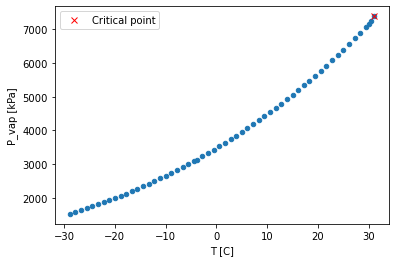

In [5]:
df.plot.scatter(x='T [C]', y='P_vap [kPa]')

T_critical = df[df['H_vap [J/g]'] == 0]['T [C]'].values
P_critical = df[df['H_vap [J/g]'] == 0]['P_vap [kPa]'].values

plt.plot(T_critical, P_critical, 'rx', label='Critical point')
plt.legend()

Let's now plot the [enthalpy of vaporization](https://en.wikipedia.org/wiki/Enthalpy_of_vaporization) which is the amount of energy that certain amount of liquid needs to be transformed into a vapor.

<AxesSubplot:xlabel='T [C]', ylabel='H_vap [J/g]'>

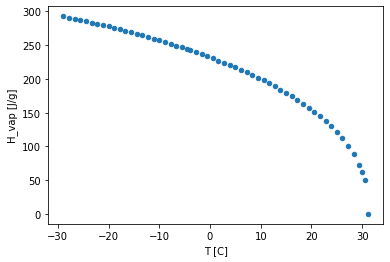

In [6]:
df.plot.scatter(x='T [C]', y='H_vap [J/g]')

From this we can clearly see that the maximum temperature in the dataset correspond to the [critical point](https://en.wikipedia.org/wiki/Critical_point_(thermodynamics)) (i.e., when the enthalpy of vaporization is zero)! As we have discovered before.

Let's quickly fit a linear model as a baseline...

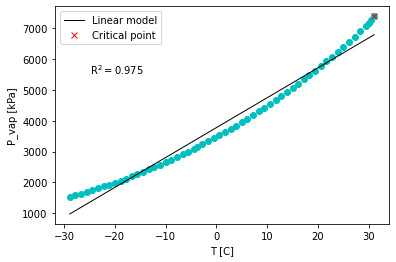

In [7]:
from sklearn.linear_model import LinearRegression

Ts = df['T [C]'].to_numpy().reshape(-1,1)
Ps = df['P_vap [kPa]'].to_numpy().reshape(-1,1)

linear_regression = LinearRegression().fit(Ts, Ps)

x_pred = np.linspace(min(Ts), max(Ts), 100)
y_pred = linear_regression.predict(x_pred)
R2 = linear_regression.score(Ts, Ps)

plt.figure()
plt.plot(Ts, Ps, 'co')
plt.plot(x_pred, y_pred,'k', linewidth=1, label='Linear model')
plt.plot(T_critical, P_critical, 'rx', label='Critical point')
plt.text(-25, 5500, 'R$^2 = $' + str(np.round(R2, 3)))
plt.xlabel('T [C]')
plt.ylabel('P_vap [kPa]')
plt.legend()

Well, the fit is not very good. But, we have knowledge of a useful relationship between vapor pressure and temperature for single components: the [Clausius–Clapeyron equation](https://en.wikipedia.org/wiki/Clausius%E2%80%93Clapeyron_relation)

$$
\ln P = - \frac{\hat{h}_{vap}}{R_sT} + c 
$$

where $\hat{h}_{vap}$ is the approximated specific enthalpy of vaporization, $R_s$ is the [specific gas constant](https://en.wikipedia.org/wiki/Gas_constant#Specific_gas_constant) and $c$ is a constant. In this equation $T$ is used in the absolute scale. Notice that this relationship assumes that the enthalpy of vaporization is constant over temperature, which we have observed not to be entirely true. Let's use this relationship and fit a linear model...

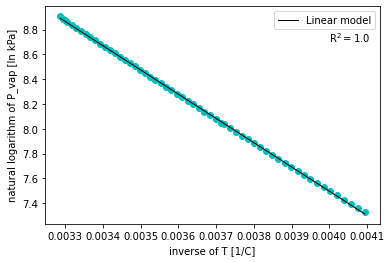

In [8]:
ln_P = np.log(Ps)
inv_T = 1/(Ts + 273.15)

linear_regression = LinearRegression().fit(inv_T, ln_P)

x_pred = np.linspace(min(inv_T), max(inv_T), 100)
y_pred = linear_regression.predict(x_pred)
R2 = linear_regression.score(inv_T, ln_P)


plt.figure()
plt.plot(inv_T, ln_P, 'co')
plt.plot(x_pred, y_pred,'k', linewidth=1, label='Linear model')
plt.text(0.004, 8.7, 'R$^2 = $' + str(np.round(R2, 3)))
plt.xlabel('inverse of T [1/C]')
plt.ylabel('natural logarithm of P_vap [ln kPa]')
plt.legend()

A valuable lesson to take from this very simple example

```{important} 
Do not by-pass the mechanistic knowledge! 
```

However, even when the Clasius-Clapeyron equation shown above gives us a very useful relationship between vapor pressure and temperature, this relationship can only be used to approximate the enthalpy of vaporization. This is because the enthalpy of vaporization depends on temperature. Let's observe this...

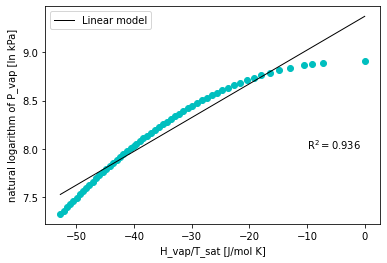

In [9]:
Hvaps = df['H_vap [J/g]'].to_numpy().reshape(-1,1)

# Change units of Hvap
mw_CO2 = 44.01 # g/mol
Hvaps = Hvaps * mw_CO2

ln_P = np.log(Ps)
neg_hvap_T = - Hvaps/(Ts + 273.15)

linear_regression = LinearRegression().fit(neg_hvap_T, ln_P)

x_pred = np.linspace(min(neg_hvap_T), max(neg_hvap_T), 100)
y_pred = linear_regression.predict(x_pred)
R2 = linear_regression.score(neg_hvap_T, ln_P)


plt.figure()
plt.plot(neg_hvap_T, ln_P, 'co')
plt.plot(x_pred, y_pred,'k', linewidth=1, label='Linear model')
plt.text(-10, 8, 'R$^2 = $' + str(np.round(R2, 3)))
plt.xlabel('H_vap/T_sat [J/mol K]')
plt.ylabel('natural logarithm of P_vap [ln kPa]')
plt.legend()

## Modeling the phase envelope of other compounds 🧪

As you can see, the relationship between vapor pressure and temperature is somehow easy to tackle. Even a linear model returns a pretty good approximation of it (combined with the knowledge of the Clasius-Clapeyron equation). A non-linear regression would also take care of the dependency of the enthalpy of vaporization with temperature.

Now, a more realistic problem would be to approximate the phase envelope of other compounds for which we do not have any experimental data. This can be seen as doing an extrapolation in the chemical space...

Can we develope a decent model for this task using deep neural networks?

Let's first get the data



In [10]:
if 'google.colab' in str(get_ipython()):
  df = pd.read_csv("https://raw.githubusercontent.com/edgarsmdn/MLCE_book/main/references/Vapor_pressures.csv")
else:
  df = pd.read_csv("references/Vapor_pressures.csv")

df.head()

,Name,CAS-RN,Formula,SMILES,T,Pvap,KDB_ID,Class,Subclass
0,METHANE,74-82-8,CH4,C,90.670000,11.702099,1,Paraffinic Hydrocarbons,n-Alkanes
1,METHANE,74-82-8,CH4,C,94.115172,17.886999,1,Paraffinic Hydrocarbons,n-Alkanes
2,METHANE,74-82-8,CH4,C,97.560345,26.489535,1,Paraffinic Hydrocarbons,n-Alkanes
3,METHANE,74-82-8,CH4,C,101.005517,38.137051,1,Paraffinic Hydrocarbons,n-Alkanes
4,METHANE,74-82-8,CH4,C,104.450690,53.534190,1,Paraffinic Hydrocarbons,n-Alkanes


This dataset contains the vapor pressures of various compounds. It has been collected from the [Korean Data Bank](https://www.cheric.org/research/kdb/). As you can see above, several identifiers are available for the compounds (e.g., name, formula, SMILES). The temperature in the dataset is given in Kelvin and the vapor presures on kPa.

Here, we will use the SMILES representation of molecules to get some input features to train our models. You can read more about SMILES [elsewhere](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system), what it is important to know for now is that SMILES is a string representation of a molecule! We can use this representation to get some molecular descriptors that will serve as input features to our models.

Here, we will use a popular vectorial representation of a molecule in cheminformatics known as molecular fingerprint. Of course, there are many types of molecular fingerprints. But, again, you can learn more about this [elsewhere](https://www.rdkit.org/docs/GettingStartedInPython.html#fingerprinting-and-molecular-similarity).

We will use here [datamol](https://datamol.io/) to get some molecular objects and fingerprints. Feel free to learn more about it on your own! This is a library that is not installed by default in Colab. Therefore, if you are using Colab, simply run the cell below, otherwise follow the installation instructions given in their [website](https://datamol.io/).

In [11]:
if 'google.colab' in str(get_ipython()):
    !pip install rdkit
    !pip install datamol

In [12]:
import datamol as dm

df['Mol'] = df['SMILES'].apply(dm.to_mol)
df['Fingerprint'] = df['Mol'].apply(dm.to_fp)

[15:27:55] WARNING: not removing hydrogen atom without neighbors
[15:27:55] WARNING: not removing hydrogen atom without neighbors
[15:27:55] WARNING: not removing hydrogen atom without neighbors
[15:27:55] WARNING: not removing hydrogen atom without neighbors
[15:27:55] WARNING: not removing hydrogen atom without neighbors
[15:27:55] WARNING: not removing hydrogen atom without neighbors
[15:27:55] WARNING: not removing hydrogen atom without neighbors
[15:27:55] WARNING: not removing hydrogen atom without neighbors
[15:27:55] WARNING: not removing hydrogen atom without neighbors
[15:27:55] WARNING: not removing hydrogen atom without neighbors
[15:27:55] WARNING: not removing hydrogen atom without neighbors
[15:27:55] WARNING: not removing hydrogen atom without neighbors
[15:27:55] WARNING: not removing hydrogen atom without neighbors
[15:27:55] WARNING: not removing hydrogen atom without neighbors
[15:27:55] WARNING: not removing hydrogen atom without neighbors
[15:27:55] WARNING: not r

Do not worry about the warning above. I appears for the hydrogen molecule (with SMILES `[HH]`). 

Now, we have a vectorial representation of each molecule: a fingerprint! Each fingerprint is an array of 2048 bit elements in which 1 denotes the presence of certain molecular substructure and 0 denotes the abscense of it.

Okay, now let's go a bit deeper into our [Exploratory Data Analysis](https://en.wikipedia.org/wiki/Exploratory_data_analysis). 

How many chemical compounds are considered in our dataset?

In [13]:
df['Name'].nunique()

1391

How many chemical classes?

In [14]:
df['Class'].nunique()

17

What about subclasses?

In [15]:
df['Subclass'].nunique()

53

 What are distributions of the covered temperatures and vapor pressures?

Text(0.5, 6.799999999999997, 'Temperature [K]')

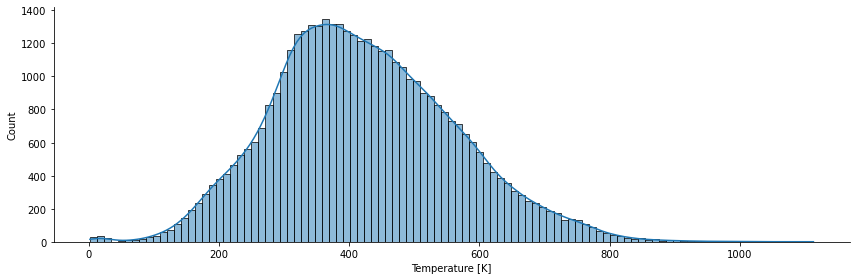

In [16]:
import seaborn as sns

sns.displot(df, kde=True, x='T', legend=True, height=4, aspect=3)
plt.xlabel('Temperature [K]')

Text(0.5, 6.799999999999997, 'Vapor Pressure [kPa]')

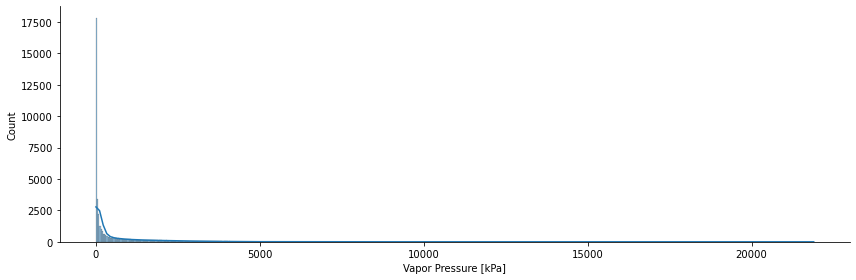

In [17]:
sns.displot(df, kde=True, x='Pvap', legend=True, height=4, aspect=3)
plt.xlabel('Vapor Pressure [kPa]')

Interesting distribution for the vapor pressure, isn't it? We have a huge range of vapor pressures in our dataset. It would make sense to scale the data using a logarithmic function. Also, do you remember the Clasius-Clapeyron equation? The vapor pressure is given in logarithmic units! So, let's go ahead and scale our data according to the Clasius-Clapeyron form.

In [18]:
df['ln_P'] = np.log(df['Pvap'])

Text(0.5, 6.799999999999997, 'ln Pvap')

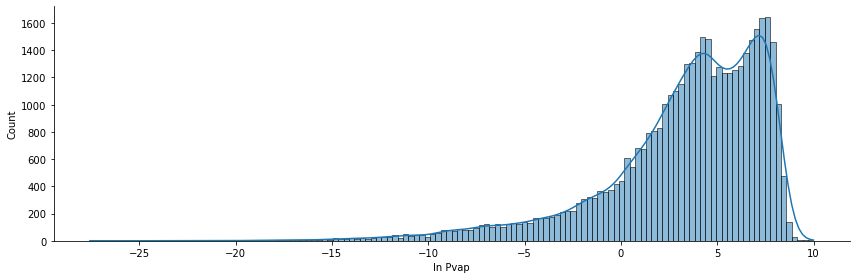

In [19]:
sns.displot(df, kde=True, x='ln_P', legend=True, height=4, aspect=3)
plt.xlabel('ln Pvap')

And we will standarize the temperature values

In [20]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df['T'].to_numpy().reshape(-1,1))

df['T_scaled'] = scaler.transform(df['T'].to_numpy().reshape(-1,1))

Let's now split the data! 

Instead of doing it blindly using a random split on the whole dataset, let's ensure that we train on certain molecules and test on other molecules. At the end of the day this was our original goal do you remember?

We can go one step further and use the information that we have available regarding the chemical classes. We will split the data in such a way that the chemical classes are well-distributed among training, validation and test. This strategy is called as [stratified splitting](https://medium.com/@analyttica/what-is-meant-by-stratified-split-289a8a986a90). Be aware that the way in which you split your data is very linked to the conclusions that you can draw from the model performance!

In [21]:
from sklearn.model_selection import train_test_split

chemical_classes = df['Class'].unique()

train_comps, valid_comps, test_comps = [], [], []
for cl in chemical_classes:
    # Get the data with this class
    df_cl = df[df['Class'] == cl]
    
    # Get unique compounds for this class
    unique_compounds_cl = df_cl['Name'].unique()
    
    # Randomly split the compounds for train and test
    comp_train_all, comp_test = train_test_split(unique_compounds_cl, test_size=0.2, random_state=0)
    comp_train, comp_valid = train_test_split(comp_train_all, test_size=0.2, random_state=1)
    
    train_comps.extend(list(comp_train))
    valid_comps.extend(list(comp_valid))
    test_comps.extend(list(comp_test))

In [22]:
df_train = df[df['Name'].isin(train_comps)]
df_valid = df[df['Name'].isin(valid_comps)]
df_test = df[df['Name'].isin(test_comps)]

Let's now extract the input and output data

In [23]:
X_train = np.vstack(df_train['Fingerprint'].tolist()) # Fingerprints to Matrix
Ts_train = df_train['T_scaled'].to_numpy().reshape(-1,1)
X_train = np.hstack((X_train, Ts_train)) # Concatenate the temperature as part of the input matrix
y_train = df_train['ln_P'].to_numpy().reshape(-1,1)

X_valid = np.vstack(df_valid['Fingerprint'].tolist()) # Fingerprints to Matrix
Ts_valid = df_valid['T_scaled'].to_numpy().reshape(-1,1)
X_valid = np.hstack((X_valid, Ts_valid)) # Concatenate the temperature as part of the input matrix
y_valid = df_valid['ln_P'].to_numpy().reshape(-1,1)

X_test = np.vstack(df_test['Fingerprint'].tolist()) # Fingerprints to Matrix
Ts_test = df_test['T_scaled'].to_numpy().reshape(-1,1)
X_test = np.hstack((X_test, Ts_test)) # Concatenate the temperature as part of the input matrix
y_test = df_test['ln_P'].to_numpy().reshape(-1,1)

### Train a Deep Neural Network

Let's now build a 2 hidden-layer neural network using PyTorch with the [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) activation function.

For doing this, we need to create a class and define the `__init__` and the `forward` functions. In `__init__` we initialize the type of layers that we are going to use and in `forward` we apply the operations.

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.manual_seed(0)

class DNN(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super(DNN, self).__init__()
        self.layer_1 = nn.Linear(in_dim, hidden_dim)
        self.layer_2 = nn.Linear(hidden_dim, hidden_dim)
        self.layer_3 = nn.Linear(hidden_dim, out_dim)
        
    def forward(self, x):
        x = F.relu(self.layer_1(x))
        x = F.relu(self.layer_2(x))
        x = self.layer_3(x)
        return x

Now, we intialize our model

In [25]:
model = DNN(X_train.shape[1], 20, 1)

We can count the number of trainable model parameters using the following function

In [26]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

41441

We have now initialized our model with some parameters using the default Kaiming uniform initilization procedure. Other intizalization procedures are also [available](https://pytorch.org/docs/master/nn.init.html).

Now, for training our model, we need to define the [loss function](https://pytorch.org/docs/stable/nn.html#loss-functions)

In [27]:
loss_function = nn.MSELoss()

and the [optimization algorithm](https://pytorch.org/docs/stable/optim.html#algorithms) to be used, for which we should pass the model parameters that will be adjusted by it and the optimizer parameters (e.g., learning rate).

In [28]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

Now, we can construct the training loop that performs the following steps:

* Forward propagation
* Backward propagation
* Update of model parameters

Notice that if you are running this from Colab, it is possible to get access to [GPUs](https://en.wikipedia.org/wiki/Graphics_processing_unit) that speed-up the training and evaluation of the model! 😃 This is one of the great advantages of using Colab!

To abilitate the GPU in Colab do the following:
1. Click on `Runtime` in the upper menu.
2. Click on `Change runtime type`.
3. On the `Hardware accelerator` select `GPU`.

```{important}
When using a GPU, you should send the model and the data to the GPU!
```

In [29]:
n_epochs = 200

# Send model and data to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
X_train_torch = torch.from_numpy(X_train).float().to(device)
y_train_torch = torch.from_numpy(y_train).float().to(device)

X_valid_torch = torch.from_numpy(X_valid).float().to(device)
y_valid_torch = torch.from_numpy(y_valid).float().to(device)

losses = np.zeros((n_epochs, 2))
for epoch in tqdm(range(n_epochs)):
    model.train()
    # Forward propagation
    y_train_pred = model(X_train_torch)
    loss = loss_function(y_train_pred, y_train_torch)
    losses[epoch,0] = loss.item()
    
    # Backward propagation
    model.zero_grad()
    loss.backward()
    
    # Update of model parameters
    optimizer.step()
    
    # Evaluate model in validation set
    model.eval()
    with torch.no_grad():
        y_valid_pred = model(X_valid_torch)
        loss = loss_function(y_valid_pred, y_valid_torch)
        losses[epoch,1] = loss.item()
    

  0%|          | 0/200 [00:00<?, ?it/s]

Let's now plot the loss function across the epochs

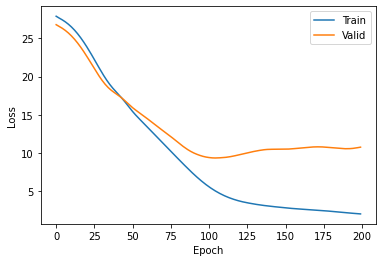

In [30]:
plt.plot(losses[:,0], label='Train')
plt.plot(losses[:,1], label='Valid')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Observe that over the epochs the model parameters are being learned and the training loss decreases. However, notice that the validation loss starts to decrease but at some point it increases again. This is a clear evidence of overfitting!

Do you remember some ways to tackle overfitting in neural networks?

### Exercise - implement Early stopping ❗❗

* Check out how early stopping was implemented [here](https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch). And apply it to the training of our previous network.

In [31]:
# Your code here

Finally, let's see the performance of the model in the test set using the [mean absolute percentage error](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error)

In [32]:
from sklearn.metrics import mean_absolute_percentage_error as MAPE

X_test_torch = torch.from_numpy(X_test).float().to(device)

model.eval()
with torch.no_grad():
    y_test_pred = model(X_test_torch).numpy()

print('MAPE: ', MAPE(y_test, y_test_pred))

MAPE:  2.7006638783311354


Quite impressive result for a general vapor pressure model of this kind right? Deep learning is indeed a powerful tool 🤓

### Hyperparameter optimization

There is still one important aspect to learn: hyperparameter optimization. In the previous implementation we used 2 hidden-layers and a constant hidden-size accross the model of 20. Also, we just decided for a learning rate of 0.002.

Let's tune one of these hyperparameters, notice that we are not going to use early stopping here, but this could be easily implemented here too! Feel free to try it out yourself

In [33]:
hidden_sizes = [5, 10, 30, 40]

In [34]:
n_epochs = 100

params_lst = list()
valid_mape_lst = list()
models = list()
for hs in hidden_sizes:
    
    model = DNN(X_train.shape[1], hs, 1)
    model = model.to(device)
    
    model_params = count_parameters(model)
    print('Hidden-size: ', hs)
    print('Model parameters: ', model_params)
    
    losses = np.zeros((n_epochs, 2))
    for epoch in tqdm(range(n_epochs)):
        model.train()
        # Forward propagation
        y_train_pred = model(X_train_torch)
        loss = loss_function(y_train_pred, y_train_torch)
        losses[epoch,0] = loss.item()

        # Backward propagation
        model.zero_grad()
        loss.backward()

        # Update of model parameters
        optimizer.step()

    # Evaluate final model in validation set
    models.append(model)
    model.eval()
    with torch.no_grad():
        y_valid_pred = model(X_valid_torch)
        mape = MAPE(y_valid_torch, y_valid_pred)
    params_lst.append(model_params)
    valid_mape_lst.append(mape)       

Hidden-size:  5
Model parameters:  10286


  0%|          | 0/100 [00:00<?, ?it/s]

Hidden-size:  10
Model parameters:  20621


  0%|          | 0/100 [00:00<?, ?it/s]

Hidden-size:  30
Model parameters:  62461


  0%|          | 0/100 [00:00<?, ?it/s]

Hidden-size:  40
Model parameters:  83681


  0%|          | 0/100 [00:00<?, ?it/s]

In [35]:
best_idx = np.argmin(valid_mape_lst)
print('Best hidden size: ', hidden_sizes[best_idx])
print('Valid MAPE', valid_mape_lst[best_idx])

Best hidden size:  30
Valid MAPE 1.0054383


In [36]:
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test_torch).numpy()

print('MAPE: ', MAPE(y_test, y_test_pred))

MAPE:  1.0324883332979344


A somehow significant improvement, right?

More efficient tools for hyperparameter optimization are available (e.g., [Ray Tune](https://docs.ray.io/en/latest/tune/index.html), [Optuna](https://optuna.org/), [HyperOpt](https://github.com/hyperopt/hyperopt)) which implement advanced techniques like Bayesian Optimization. Feel free to try them out!

## References

```{bibliography}
:filter: docname in docnames
```